# Spam vs. Ham Email Classifier

The following notebook contains the analysis of email data containing the subject line, email body, and an indicator variable denoting whether or not an email is legitimate (ham) or spam. Data from `email_test.csv` will be used to create a logistic regression model, capable of processing test data and generating predictions.

## Data Loading, Cleaning, and Processing

In [96]:
# Importing necessary libraries for data manipulation and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from os import get_terminal_size
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Loading and Cleaning Data

In [44]:
train = pd.read_csv('data/emails_train.csv')
print('First 5 rows of training data:')
display(train.head())

First 5 rows of training data:


,id,subject,email,spam
0,0,Subject: A&L Daily to be auctioned in bankrupt...,URL: http://boingboing.net/#85534171\n Date: N...,0
1,1,"Subject: Wired: ""Stronger ties between ISPs an...",URL: http://scriptingnews.userland.com/backiss...,0
2,2,Subject: It's just too small ...,<HTML>\n <HEAD>\n </HEAD>\n <BODY>\n <FONT SIZ...,1
3,3,Subject: liberal defnitions\n,Depends on how much over spending vs. how much...,0
4,4,Subject: RE: [ILUG] Newbie seeks advice - Suse...,hehe sorry but if you hit caps lock twice the ...,0


In [45]:
# Clean data by imputing any missing/NaN values
print(f'Before imputation:\n{train.isnull().sum()}')
train = train.fillna('')
print('----------')
print(f'After imputation:\n{train.isnull().sum()}')

Before imputation:
id         0
subject    6
email      0
spam       0
dtype: int64
----------
After imputation:
id         0
subject    0
email      0
spam       0
dtype: int64


In [49]:
# Begin data processing by converting both subject line and email bodies to lowercase
def df_to_lower(df):
    """
    Args:
        df (DataFrame): Data to be converted to lowercase
    
    Returns:
        df (DataFrame): Converted dataframe in lowercase
    """
    df['subject'] = df['subject'].str.lower()
    df['email'] = df['email'].str.lower()
    return df

print('First 5 rows of training data:')
df_to_lower(train).head()

First 5 rows of training data:


,id,subject,email,spam
0,0,subject: a&l daily to be auctioned in bankrupt...,url: http://boingboing.net/#85534171\n date: n...,0
1,1,"subject: wired: ""stronger ties between isps an...",url: http://scriptingnews.userland.com/backiss...,0
2,2,subject: it's just too small ...,<html>\n <head>\n </head>\n <body>\n <font siz...,1
3,3,subject: liberal defnitions\n,depends on how much over spending vs. how much...,0
4,4,subject: re: [ilug] newbie seeks advice - suse...,hehe sorry but if you hit caps lock twice the ...,0


### Exploratory Data Analysis (EDA)

In [47]:
# Define utility function to identify words in email bodies
def words_in_texts(words, texts):
    """
    Args:
        words (list): Words to find.
        texts (Series): Strings to search in.

    Returns:
        indicator_array (np.ndarray): A 2D NumPy array
        of binary values with shape (n, d) where n is
        the number of texts, and d is the number of 
        words.
    """
    indicator_array = np.array([texts.str.contains(word) for word in words]).T.astype('int')

    return indicator_array

In [48]:
# Investigate certain rows of the data to identify potential features
print(f'Ham email body example:\n------------\n{train.iloc[0][2]}')
print(f'Spam email body example:\n------------\n{train.iloc[2][2]}')

Ham email body example:
------------
url: http://boingboing.net/#85534171
 date: not supplied
 
 arts and letters daily, a wonderful and dense blog, has folded up its tent due 
 to the bankruptcy of its parent company. a&l daily will be auctioned off by the 
 receivers. link[1] discuss[2] (_thanks, misha!_)
 
 [1] http://www.aldaily.com/
 [2] http://www.quicktopic.com/boing/h/zlfterjnd6jf
 
 

Spam email body example:
------------
<html>
 <head>
 </head>
 <body>
 <font size=3d"4"><b> a man endowed with a 7-8" hammer is simply<br>
  better equipped than a man with a 5-6"hammer. <br>
 <br>would you rather have<br>more than enough to get the job done or fall =
 short. it's totally up<br>to you. our methods are guaranteed to increase y=
 our size by 1-3"<br> <a href=3d"http://209.163.187.47/cgi-bin/index.php?10=
 004">come in here and see how</a>
 </body>
 </html>
 
 
 



As seen above, one of the key features that can help differntiate between spam and ham emails are the presence of HTML tags. Additionally, the presence of a link to an IP address instead of a legitimate website can be used as an indicator for potential spam emails.

In [53]:
# Define a function to find the most occurring word in an email
from collections import Counter
import re

def most_occurring_word(email):
    """
    Args:
        email (Series): Series of email body text data
    
    Returns:
        most_common (string): Most occurring word in an email body
    """
    words = re.findall(r'\w+', email.lower())
    word_counter = Counter(words)

    most_common = max(word_counter, key=word_counter.get)

    return most_common

# Apply to training data
train_copy = train.copy()
train_copy['most_occurring'] = train_copy['email'].apply(most_occurring_word)
print(f'First 5 rows of training data, including the most occurring word in `email`:')
display(train_copy.head())

First 5 rows of training data, including the most occurring word in `email`:


,id,subject,email,spam,most_occurring
0,0,subject: a&l daily to be auctioned in bankrupt...,url: http://boingboing.net/#85534171\n date: n...,0,http
1,1,"subject: wired: ""stronger ties between isps an...",url: http://scriptingnews.userland.com/backiss...,0,http
2,2,subject: it's just too small ...,<html>\n <head>\n </head>\n <body>\n <font siz...,1,a
3,3,subject: liberal defnitions\n,depends on how much over spending vs. how much...,0,the
4,4,subject: re: [ilug] newbie seeks advice - suse...,hehe sorry but if you hit caps lock twice the ...,0,linux


In [72]:
# Perform a groupby operation to see which words occur most frequently in spam emails over ham emails
train_group = train_copy.groupby(['most_occurring', 'spam']).count().drop(['subject', 'email'], axis=1).rename(columns={'id':'count'}).sort_values(['count'], ascending=False)
print('Top 10 most occurring words in ham emails:')
display(train_group.xs(0, level=1).head(10))
print('Top 10 most occurring words in spam emails:')
train_group.xs(1, level=1).head(10)

Top 10 most occurring words in ham emails:


,count
most_occurring,
the,2016
i,447
a,399
to,388
http,253
url,220
linux,133
and,120
of,110


Top 10 most occurring words in spam emails:


,count
most_occurring,
3d,323
font,245
the,206
to,189
br,160
you,96
td,78
content,64
p,55


The most occurring words in spam emails, besides obvious ones like "the", "to", "you", and "a", all seem to be those derived from HTML tags: "3d", "font", "br" (line break), "td" (table data), "content", and "p" (paragraph). We'll use the first five words as our "words of interest" for modeling.

,most_occurring,spam,count
4,3d,1,323
6,font,1,245
10,br,1,160
15,td,0,101
20,td,1,78
25,content,1,64
30,3d,0,51
46,content,0,24
47,font,0,22
121,br,0,5


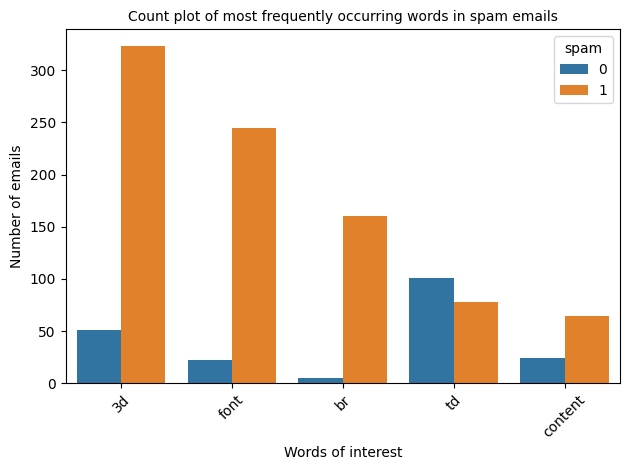

In [74]:
# Define the words of interest from spam emails and visualize their counts compared to in ham emails
words_of_interest = ['3d', 'font', 'br', 'td', 'content']
woi_df = train_group.reset_index()
woi_df = woi_df[woi_df['most_occurring'].isin(words_of_interest)]
display(woi_df)

# Generate a plot to better visualize what's shown in the above dataframe
sns.barplot(data=woi_df, x='most_occurring', y='count', hue='spam')
plt.xticks(rotation=45)
plt.xlabel('Words of interest')
plt.ylabel('Number of emails')
plt.title('Count plot of most frequently occurring words in spam emails', fontsize=10)
plt.tight_layout()

Part of the data science lifecycle is generating insights through visualizations and making changes based on these insights. The "td" tag, thought to be very common in spam emails, happens to be common in ham emails as well. Since we are creating a model to better differentiate between the two, it's best to leave it out of the words of interest list, in order to better train our model on more defining features.

In [76]:
# Change `words_of_interest` to not include "td" and create a dataframe using the utility functions, composed of indicators for each word features
train_woi = pd.DataFrame(words_in_texts(words_of_interest, train['email']), columns=words_of_interest)
print('First 5 rows of indicator data based on the presence of each word of interest:')
display(train_woi.head())

# Sanity check that the length of `train` and `train_woi` are equal
assert(len(train) == len(train_woi))

First 5 rows of indicator data based on the presence of each word of interest:


,3d,font,br,td,content
0,0,0,0,0,0
1,0,0,0,0,0
2,1,1,1,0,0
3,0,0,0,0,0
4,0,0,1,0,0


In [82]:
# Perform operations to identify possible features for modeling
def transformations(df):
    df['html_tags'] = df['email'].str.count('<.*?\>')
    df['body_characters'] = df['email'].str.len()
    df['body_length'] = df['email'].str.split().str.len()
    df['subj_length'] = df['subject'].str.split().str.len()
    df['exclamations'] = df['email'].str.count('!')
    df['is_reply'] = df['subject'].str.contains('re:').astype('int')
    df['has_ip'] = df['email'].str.contains('\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}').astype('int')
    return df

print('Training data before feature transformations:')
display(train.head())
print('Training data after feature transformations:')
train = transformations(train)
train.head()

Training data before feature transformations:


,id,subject,email,spam,html_tags,body_characters,body_length,subj_length,exclamations,is_reply,has_ip
0,0,subject: a&l daily to be auctioned in bankrupt...,url: http://boingboing.net/#85534171\n date: n...,0,0,359,44,8,1,0,0
1,1,"subject: wired: ""stronger ties between isps an...",url: http://scriptingnews.userland.com/backiss...,0,0,278,23,9,0,0,0
2,2,subject: it's just too small ...,<html>\n <head>\n </head>\n <body>\n <font siz...,1,15,444,64,6,0,0,1
3,3,subject: liberal defnitions\n,depends on how much over spending vs. how much...,0,0,1500,238,3,0,0,0
4,4,subject: re: [ilug] newbie seeks advice - suse...,hehe sorry but if you hit caps lock twice the ...,0,0,2018,317,9,1,0,0


Training data after feature transformations:


,id,subject,email,spam,html_tags,body_characters,body_length,subj_length,exclamations,is_reply,has_ip
0,0,subject: a&l daily to be auctioned in bankrupt...,url: http://boingboing.net/#85534171\n date: n...,0,0,359,44,8,1,0,0
1,1,"subject: wired: ""stronger ties between isps an...",url: http://scriptingnews.userland.com/backiss...,0,0,278,23,9,0,0,0
2,2,subject: it's just too small ...,<html>\n <head>\n </head>\n <body>\n <font siz...,1,15,444,64,6,0,0,1
3,3,subject: liberal defnitions\n,depends on how much over spending vs. how much...,0,0,1500,238,3,0,0,0
4,4,subject: re: [ilug] newbie seeks advice - suse...,hehe sorry but if you hit caps lock twice the ...,0,0,2018,317,9,1,1,0


In [83]:
# Perform group by transformation to visualize differences in mean values of the newly-added features
train_group_features = train.groupby('spam').mean(numeric_only=True).drop('id', axis=1)
train_group_features

,html_tags,body_characters,body_length,subj_length,exclamations,is_reply,has_ip
spam,,,,,,,
0,30.588756,2962.651095,332.046231,6.793653,2.096811,0.509504,0.019169
1,82.602804,5449.257009,458.399065,6.878972,6.457009,0.049533,0.212617


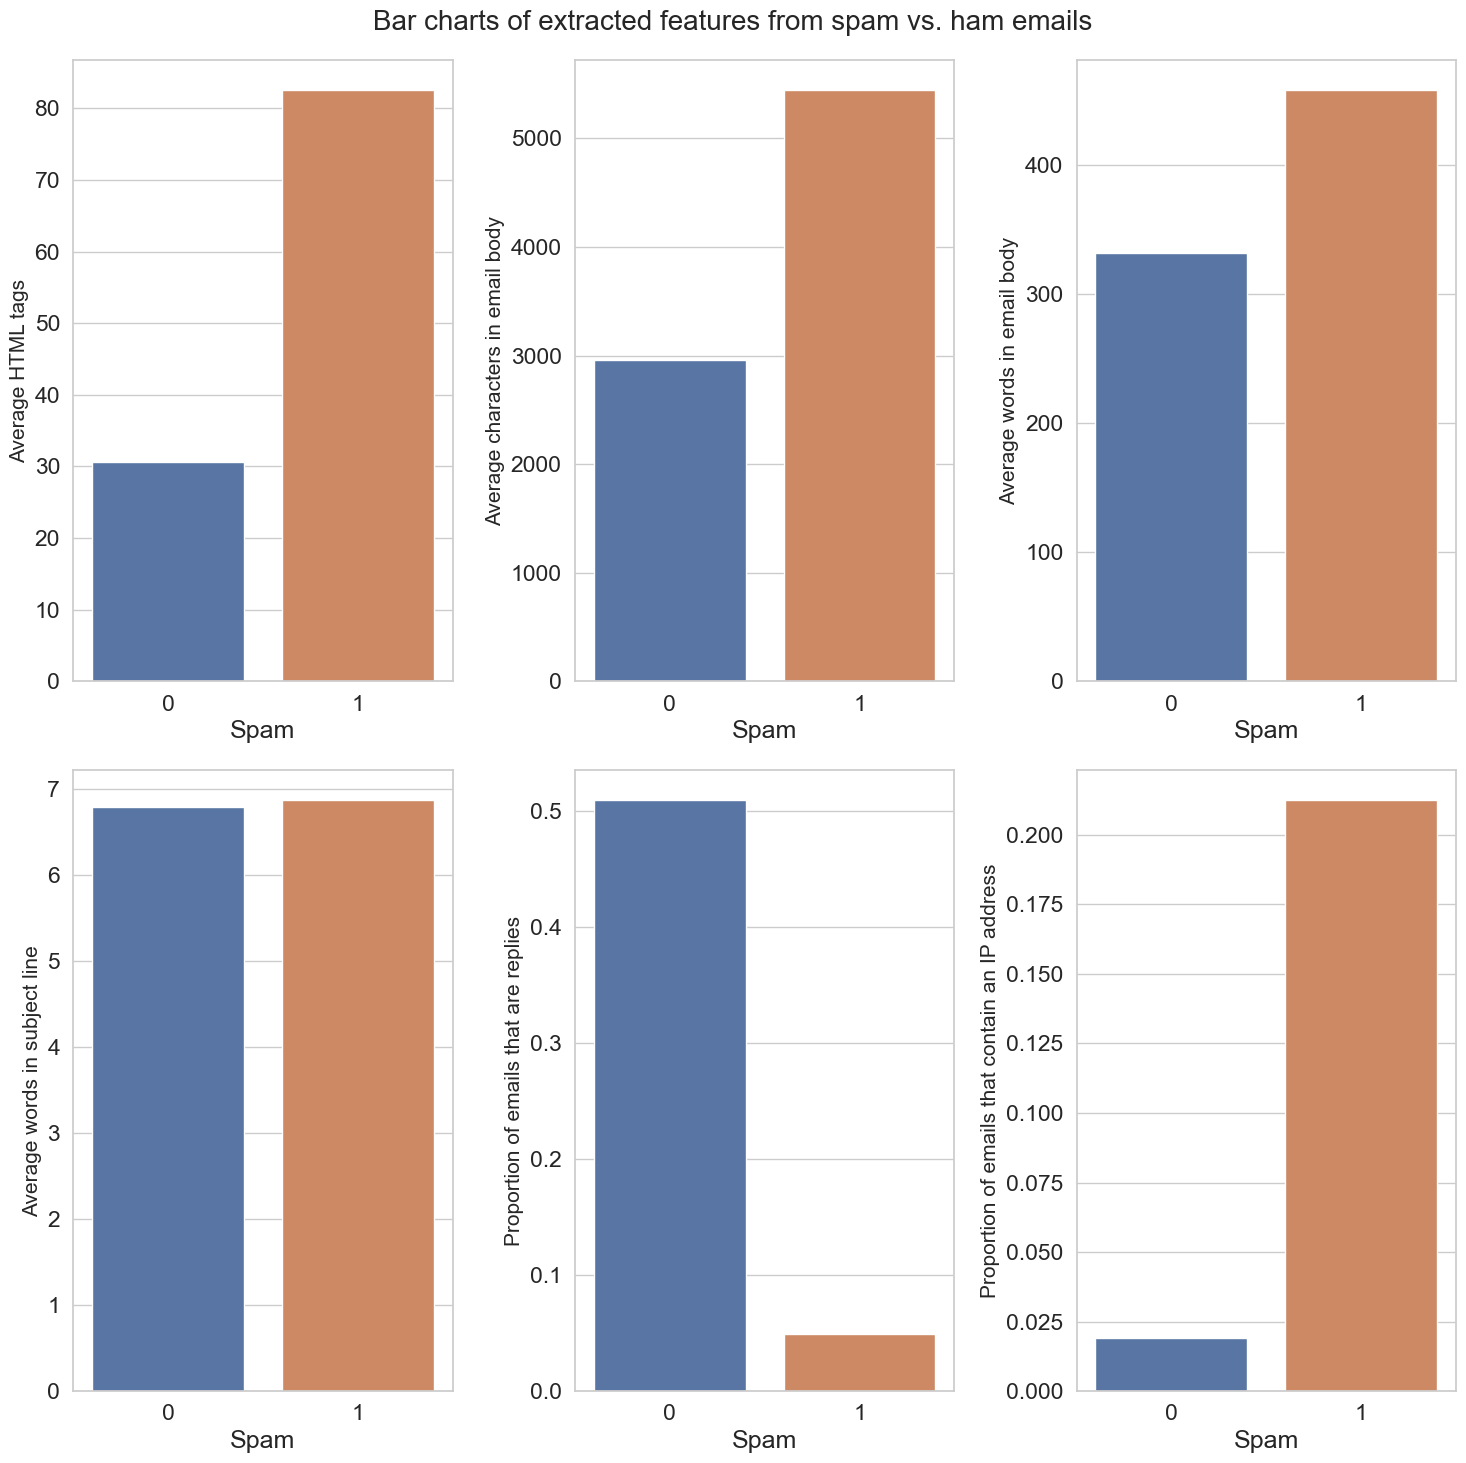

In [93]:
# Visualize the above differences through bar charts
fig, axs = plt.subplots(2, 3, figsize=(15,15))

sns.barplot(data=train_group_features, 
            x=train_group_features.index, 
            y=train_group_features['html_tags'], 
            ax=axs[0,0], 
            hue=train_group_features.index,
            legend=False)
axs[0,0].set_ylabel('Average HTML tags', fontsize=15)
axs[0,0].set_xlabel('Spam')

sns.barplot(data=train_group_features, 
            x=train_group_features.index, 
            y=train_group_features['body_characters'], 
            ax=axs[0,1], 
            hue=train_group_features.index,
            legend=False)
axs[0,1].set_ylabel('Average characters in email body', fontsize=15)
axs[0,1].set_xlabel('Spam')

sns.barplot(data=train_group_features,
            x=train_group_features.index,
            y=train_group_features['body_length'],
            ax=axs[0,2],
            hue=train_group_features.index,
            legend=False)
axs[0,2].set_ylabel('Average words in email body', fontsize=15)
axs[0,2].set_xlabel('Spam')

sns.barplot(data=train_group_features, 
            x=train_group_features.index, 
            y=train_group_features['subj_length'], 
            ax=axs[1,0], 
            hue=train_group_features.index,
            legend=False)
axs[1,0].set_ylabel('Average words in subject line', fontsize=15)
axs[1,0].set_xlabel('Spam')

sns.barplot(data=train_group_features,
            x=train_group_features.index,
            y=train_group_features['is_reply'],
            ax=axs[1,1],
            hue=train_group_features.index,
            legend=False)
axs[1,1].set_ylabel('Proportion of emails that are replies', fontsize=15)
axs[1,1].set_xlabel('Spam')

sns.barplot(data=train_group_features,
            x=train_group_features.index,
            y=train_group_features['has_ip'],
            ax=axs[1,2],
            hue=train_group_features.index,
            legend=False)
axs[1,2].set_ylabel('Proportion of emails that contain an IP address', fontsize=15)
axs[1,2].set_xlabel('Spam')

fig.suptitle('Bar charts of extracted features from spam vs. ham emails', fontsize=20)
plt.tight_layout()
plt.show()

From the visualizations above, we can see that spam emails tend to have more HTML tags, more characters and words in email body. Spam emails are often times more likely to have an IP address somewhere in their content. Conversely, legitimate emails are likely to be replies, presumably due to spam emails being sent unprompted. The one feature that will most likely not benefit our model is the subject line word count, as the difference in average length between spam and ham emails is not as pronounced as our other features. We'll take that into account soon during the model training step.

In [99]:
# Concatenate the training data to the word data extracted from earlier
train = pd.concat([train, train_woi], axis=1)
train.head()

,id,subject,email,spam,html_tags,body_characters,body_length,subj_length,exclamations,is_reply,has_ip,3d,font,br,td,content
0,0,subject: a&l daily to be auctioned in bankrupt...,url: http://boingboing.net/#85534171\n date: n...,0,0,359,44,8,1,0,0,0,0,0,0,0
1,1,"subject: wired: ""stronger ties between isps an...",url: http://scriptingnews.userland.com/backiss...,0,0,278,23,9,0,0,0,0,0,0,0,0
2,2,subject: it's just too small ...,<html>\n <head>\n </head>\n <body>\n <font siz...,1,15,444,64,6,0,0,1,1,1,1,0,0
3,3,subject: liberal defnitions\n,depends on how much over spending vs. how much...,0,0,1500,238,3,0,0,0,0,0,0,0,0
4,4,subject: re: [ilug] newbie seeks advice - suse...,hehe sorry but if you hit caps lock twice the ...,0,0,2018,317,9,1,1,0,0,0,1,0,0


## Data Modeling

In [119]:
# Importing necessary libraries for modeling
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_curve

### Model Building

In [118]:
# Define processed as features X and outcome y
X = train.iloc[:, 4:]
y = train['spam']

# Split data into training and validation sets and define a pipeline
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
pipe = make_pipeline(StandardScaler(), LogisticRegression()) # First scales data, then trains a logistic regression model
pipe.fit(X_train, y_train)

# Generate predictions and scores for training, validation, and cross-validation
train_preds = pipe.predict(X_train)
val_preds = pipe.predict(X_val)
print(f'Training accuracy: {accuracy_score(train_preds, y_train)}\nValidation accuracy: {accuracy_score(val_preds, y_val)}')
print(f'Average cross-validation score across 10 folds: {cross_val_score(pipe, X, y, cv=10).mean()}')

Training accuracy: 0.861036238394729
Validation accuracy: 0.8634730538922155
Average cross-validation score across 10 folds: 0.8614048162667471


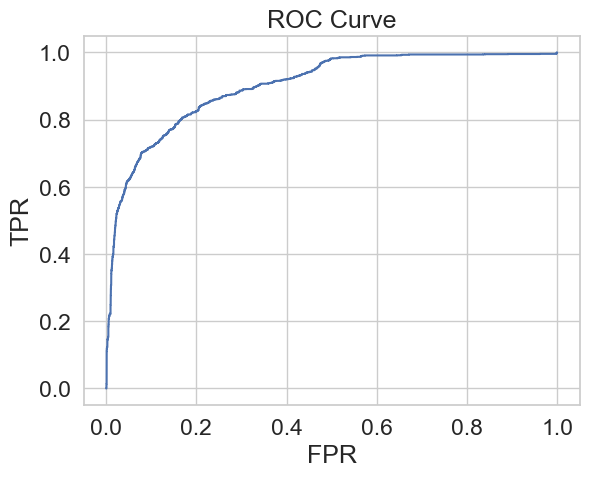

In [123]:
# Generate receiver operating characteristic (ROC) curve as another metric of model performance
train_probs = pipe.predict_proba(X)[::,1]
fpr, tpr, _ = roc_curve(y, train_probs)

plt.plot(fpr, tpr)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve");

All in all, the model seems to perform pretty well, considering that the accuracy is consistently over 85% across the training, validation, and cross-validation sets, along with the ROC curve having the characteristic shape of a well-performing model (concavity).

### Exporting Model

In [124]:
# Import module for saving trained models
import pickle

In [126]:
# Saving model to local repository
with open('model/spam-vs-ham.pkl', 'wb') as f:
    pickle.dump(pipe, f)

With this model, we are able to use it to make predictions on other input data, so long as the inputs are properly processed to include the features the model was trained upon. Stay tuned for the Spam vs. Ham web application, capable of taking in an input email text and predicting whether or not the email is spam or not!